In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from main import read_in_blicks, BOUNDARY, eval_auc, cost_to_prob
from run_english_batch import *
import scorers
import datasets
import informants
import learners
from tqdm import tqdm

from util import entropy, kl_bern
from analyze_english_batch import * 

In [3]:
import pandas as pd

In [4]:
feature_type = 'english'
SEED=1

In [5]:
informant, mf_scorer = load_informant_scorer(feature_type)

Loading lexicon from:	data/hw/english_lexicon.txt
Loading lexicon with min_length=2, max_length=5...
Reading phoneme features from: data/hw/english_features.txt
# features:  54872
feature type:  english
Reading phoneme features from: data/hw/english_features.txt
Loading ngram features from: data/hw/english_feature_weights.txt


## Load eval dataset

In [6]:
eval_dataset = load_eval_dataset(informant, mf_scorer)
display(eval_dataset)

100%|██████████| 12390/12390 [01:32<00:00, 133.52it/s]


,item,label,encoded,featurized,source,cost
1054,[AW],False,"(0, 26, 0)","[52058, 52134, 52172, 52552, 53008, 53236]",5,3.233
1055,[IH],False,"(0, 14, 0)","[52058, 52134, 52172, 53008, 53122, 53198, 532...",5,6.983
1056,[UH],False,"(0, 38, 0)","[52058, 52134, 52172, 52552, 53008, 53084, 531...",5,11.848
1057,[DH],True,"(0, 39, 0)","[52020, 52134, 52210, 52248, 52400, 52628, 527...",5,0.000
1058,[R],True,"(0, 12, 0)","[52058, 52096, 52172, 52628, 52742, 52818]",5,0.000
...,...,...,...,...,...,...
12385,"[S, T, IY, ER, V, IY, AA, Z]",True,"(0, 6, 10, 11, 20, 13, 11, 17, 25, 0)","[1, 3, 4, 26, 29, 30, 33, 34, 39, 40, 41, 42, ...",5,0.000
12386,"[B, AO, R, EH, B, R, G, OW]",True,"(0, 3, 22, 12, 19, 3, 12, 28, 15, 0)","[38, 39, 40, 41, 42, 43, 45, 48, 54, 57, 59, 6...",5,0.000
12387,"[ER, IH, Z, AH, N, ER, AA, P]",True,"(0, 20, 14, 25, 2, 7, 20, 17, 29, 0)","[38, 39, 41, 42, 46, 54, 56, 59, 65, 66, 69, 7...",5,0.000
12388,"[DH, IH, TH, R, S, W, AE, D]",True,"(0, 39, 14, 37, 12, 6, 34, 4, 8, 0)","[38, 39, 41, 42, 43, 44, 49, 54, 56, 58, 59, 6...",5,0.000


In [7]:
TRAIN_CACHES = {}


In [8]:
# !rm -r temp_files

In [21]:
df_1128 = get_wandb_runs(project='lm-informants/1128_big_batch')
df_1114 = get_wandb_runs(project='lm-informants/1114_big_batch')

  5%|▍         | 1/21 [00:00<00:02,  6.79it/s]

Skipping run rmifkuew because status is running


 24%|██▍       | 8/33 [00:06<00:14,  1.75it/s]

Skipping run ra4xck2j because status is failed
Skipping run b8l4fqzq because status is failed


100%|██████████| 33/33 [00:33<00:00,  1.00s/it]


In [32]:
def get_results(df, lla=0.522731931474557, prior_prob=0.00138533389897108, num_samples='None', max_updates='None', tol=0.000002):

    probs_by_train_file = {}
    costs_by_train_file = {}
    aucs_by_train_file = {}
    feature_type = "english"
    length_norm = False

    # lla = 0.522731931474557
    # # lla = 5.41687946870128
    # # prior_prob = 0.00240504883318384
    # prior_prob = 0.00138533389897108
    # max_updates='None'
    # # max_updates = 1
    # # 'None'
    # # tol = 0.000002
    # # train_file_short = 'hw_babble'
    # # train_file_short = 'random_strings'
    # # num_samples=10
    # num_samples='None'
    # tol = 0.000002

    # print("max updates:", max_updates)
    for train_file_short in ['hw_babble', 'eval', "prior"]:
        

        if train_file_short == "prior":
            probs_1 = np.array([prior_prob]*len(mf_scorer.probs))

        else:
            exp = get_exp(df, lla, prior_prob, max_updates, train_file_short, num_samples=num_samples)
            probs_1 = exp['probs']

        # these hyperparams are dummy 
        scorer = initialize_hyp(lla, prior_prob, tol, max_updates, informant.dataset, 'data/hw/english_features.txt')

        scorer.probs = probs_1
        costs = [scorer.cost(encod, length_norm=length_norm) for encod in eval_dataset['encoded'].values]
        auc = get_auc(scorer, eval_dataset, length_norm=length_norm)
        # assert auc == exp['auc'], f'{auc} != {exp["auc"]}'
        title = f'train file: {train_file_short} (auc = {round(auc, 3)})\n'

        # print(probs_1)
        # print(probs_1.mean())

        # get_roc_curve(probs_1, eval_dataset, costs=costs) 

        probs_by_train_file[train_file_short] = probs_1
        costs_by_train_file[train_file_short] = costs
        aucs_by_train_file[train_file_short] = auc
        # plot_learned_weights_compare(probs_1, title=title)
        # plot_learned_weights(probs_1, title=title)
        # plot_eval_costs_by_label(probs_1, exp['config'], eval_dataset, title=title, costs=costs)
    
    return probs_by_train_file, costs_by_train_file, aucs_by_train_file





RESULTS FOR: no_weight
Initializing learner...
Reading phoneme features from: data/hw/english_features.txt
# features:  54872
Initializing learner...
Reading phoneme features from: data/hw/english_features.txt
# features:  54872
Initializing learner...
Reading phoneme features from: data/hw/english_features.txt
# features:  54872

alpha: 0.6277863610440261
acc for hw_babble: 0.516
auc for hw_babble: 0.682
mean prob true for hw_babble: 0.3779 (0.0368)
log likelihood for hw_babble: -8141.486
entropy over features for hw_babble: 2570.1431
bound for hw_babble: -5571.3429

alpha: 0.6277863610440261
acc for eval: 0.496
auc for eval: 0.598
mean prob true for eval: 0.3724 (0.0063)
log likelihood for eval: -8263.387
entropy over features for eval: 2147.4243
bound for eval: -6115.9627

alpha: 0.6277863610440261
acc for prior: 0.497
auc for prior: 0.503
mean prob true for prior: 0.428 (0.0437)
log likelihood for prior: -8038.578
entropy over features for prior: 576.2868
bound for prior: -7462

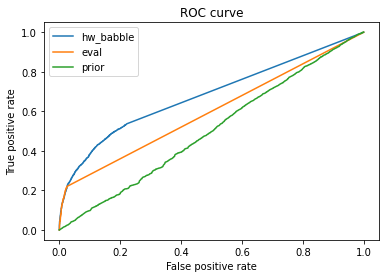





RESULTS FOR: entropy_weight_0.1
Initializing learner...
Reading phoneme features from: data/hw/english_features.txt
# features:  54872
Initializing learner...
Reading phoneme features from: data/hw/english_features.txt
# features:  54872
Initializing learner...
Reading phoneme features from: data/hw/english_features.txt
# features:  54872

alpha: 0.6277863610440261
acc for hw_babble: 0.496
auc for hw_babble: 0.495
mean prob true for hw_babble: 0.3723 (0.0058)
log likelihood for hw_babble: -8267.03
entropy over features for hw_babble: 21453.6126
bound for hw_babble: 13186.583

alpha: 0.6277863610440261
acc for eval: 0.496
auc for eval: 0.496
mean prob true for eval: 0.3722 (0.0001)
log likelihood for eval: -8267.027
entropy over features for eval: 22083.0062
bound for eval: 13815.9797

alpha: 0.6277863610440261
acc for prior: 0.497
auc for prior: 0.503
mean prob true for prior: 0.428 (0.0437)
log likelihood for prior: -8038.578
entropy over features for prior: 576.2868
bound for pri

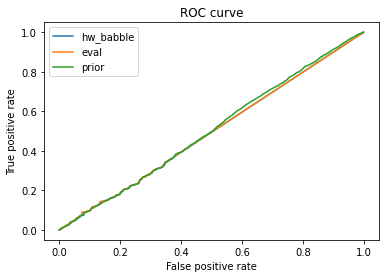

In [34]:
entropy_weight_df = df_1128[df_1128['tag']=='entropy_weight_0.1']
no_weight_df = df_1114[df_1114['tag']=='None']

lla = 0.522731931474557

# display(no_weight_df)

for (label, temp_df) in [
    ('no_weight', no_weight_df),
    ('entropy_weight_0.1', entropy_weight_df), 
    ]:
    print('\n\n\n')
    print(f"RESULTS FOR: {label}")

    probs_by_train_file, costs_by_train_file, aucs_by_train_file = get_results(temp_df, lla=lla)

    # plot roc curves on same plot
    for train_file_short, probs in probs_by_train_file.items():
        print()
        costs = costs_by_train_file[train_file_short]
        get_roc_curve(probs, eval_dataset, costs=costs, label=train_file_short, do_show=False)
        acc = get_classification_accuracy(probs, eval_dataset, costs=costs, threshold=0.5)
        # lla = exp['config']['log_log_alpha_ratio']
        alpha = compute_alpha(lla)
        log_likelihood = get_log_likelihood(lla, eval_dataset, costs)
        print(f"acc for {train_file_short}: {round(acc, 3)}")
        print(f"auc for {train_file_short}: {round(aucs_by_train_file[train_file_short], 3)}")
        mean, std = get_average_prob_true(costs, alpha)
        print(f"mean prob true for {train_file_short}: {round(mean, 4)} ({round(std, 4)})")

        entropy_over_feats = entropy(probs)
        print(f"log likelihood for {train_file_short}: {round(log_likelihood, 3)}")
        print(f"entropy over features for {train_file_short}: {round(entropy_over_feats, 4)}")
        bound = log_likelihood + entropy_over_feats
        print(f"bound for {train_file_short}: {round(bound, 4)}")

    plt.show()




max_updates: None

alpha: 0.6277863610440261
acc for hw_babble: 0.496
auc for hw_babble: 0.495
mean prob true for hw_babble: 0.3723 (0.0058)
log likelihood for hw_babble: -8267.03
entropy over features for hw_babble: 21453.6126
bound for hw_babble: 13186.583

alpha: 0.6277863610440261
acc for eval: 0.496
auc for eval: 0.496
mean prob true for eval: 0.3722 (0.0001)
log likelihood for eval: -8267.027
entropy over features for eval: 22083.0062
bound for eval: 13815.9797

alpha: 0.6277863610440261
acc for None: 0.497
auc for None: 0.503
mean prob true for None: 0.428 (0.0437)
log likelihood for None: -8038.578
entropy over features for None: 576.2868
bound for None: -7462.291


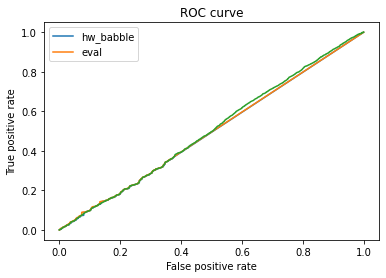

## Old stuff

In [ ]:
for feat_idx, weight in enumerate(eval_row['probs']):
    print(feat_idx, round(weight, 4), indices_to_feats[feat_idx], indices_to_feats_encoded[feat_idx])
    

In [109]:
for (feat_template, weight) in informant.scorer.ngram_features[2]:
    print(feat_template)
    print(weight)
    print(informant.scorer.pp_feature(feat_template))
    print()
    

((6,), (10,))
1.967
[+continuant] [+voice]

((3, 31), (3, 1))
3.324
[-approximant, -tense] [-approximant, -consonantal]

((3, 31), (33,))
1.802
[-approximant, -tense] [-low]

((11,), (10,))
2.787
[-voice] [+voice]

((3, 28), (3, 14, 1))
1.053
[-approximant, +back] [-approximant, +labial, -consonantal]

((10, 16), (20,))
2.824
[+voice, +coronal] [+strident]

((6,), (6, 20))
3.679
[+continuant] [+continuant, +strident]

((32,), (26, 28))
0.449
[+low] [+high, +back]

((7, 16), (7,))
3.275
[-continuant, +coronal] [-continuant]

((6, 10), (5, 16))
0.054
[+continuant, +voice] [-sonorant, +coronal]

((6, 10), (11,))
3.031
[+continuant, +voice] [-voice]

((3, 19), (0,))
4.383
[-approximant, -anterior] [+consonantal]

((36,), (3, 26, 28))
2.826
[+word_boundary] [-approximant, +high, +back]

((3, 1), (3, 26, 28))
1.693
[-approximant, -consonantal] [-approximant, +high, +back]

((32,), (3, 14, 26))
0.81
[+low] [-approximant, +labial, +high]

((3, 27, 29), (30, 33))
0.972
[-approximant, -high, -ba

In [ ]:
informant.scorer.pp_feature(((36,), (7,), (3, 0)))

In [ ]:
for k, v in informant.scorer.ngram_features.items():
    print(k)
    print(len(v))
    print(v)

In [ ]:
print(informant.scorer.ngram_features)

In [ ]:
for feat, feat_idx in mf_scorer.ngram_features.items():
    decoded = (mf_scorer.feature_vocab.decode(feat))
    print(feat_idx, decoded)

In [ ]:
train_dataset = load_train_dataset('data/MakingOverTrainSet/EnglishOverTrainingData.csv', informant, mf_scorer)
display(train_dataset)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

In [ ]:
train_files = [
    'data/MakingOverTrainSet/EnglishOverTrainingData.csv',
    'data/BabbleRandomStringsEnglish/RandomStringsSubsampledBalanced.csv',
    'data/BabbleRandomStringsEnglish/RandomWellFormedSyllablesSubsampledBalanced.csv',    
]

train_datasets = [load_train_dataset(f, informant, mf_scorer) for f in train_files]


In [ ]:
for (train_file, train_dataset) in zip(train_files, train_datasets):
#     train_dataset = load_train_dataset(train_file, informant, mf_scorer)
    plot_histogram_scores(train_dataset, title=f'Histogram of Scores:\n{train_file}')
    plot_histogram_labels(train_dataset, title=f'Histogram of Scores:\n{train_file}')
    

In [ ]:
eval_dataset = load_eval_dataset(informant, mf_scorer)

100%|██████████| 12390/12390 [00:33<00:00, 372.00it/s]


In [ ]:
# eval_dataset = load_eval_dataset(informant, mf_scorer)
plot_histogram_scores(eval_dataset, title=f'Histogram of Scores:\nEVAL')
plot_histogram_labels(eval_dataset, title=f'Histogram of Labels:\nEVAL')

In [ ]:
eval_dataset['label'].value_counts()

In [ ]:
for td in train_datasets:
#     print(td['item'].value_counts().max())
    print(len(td))